In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython import get_ipython
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import csv
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
from multiprocess import Pool
import time
warnings.filterwarnings('ignore')

In [14]:
cdx = "CDX IG CDSI GEN 5Y SPRD CORP"
bond_etf = "VCIT US EQUITY"
cdx_name = "CDX IG 5Y"
rates_etf = "USGG5YR INDEX"
rates_etf_name = "US 5Y"

# cdx = "CDX HY CDSI GEN 5Y SPRD CORP"
# bond_etf = "HYG US EQUITY"
# cdx_name = "CDX HY 5Y"
# rates_etf = "USGG5YR INDEX"
# rates_etf_name = "US 5Y"

# cdx = "CDX EM CDSI GEN 5Y SPRD CORP"
# bond_etf = "EMB US EQUITY"
# cdx_name = "CDX EM 5Y"
# rates_etf = "USGG7YR INDEX"
# rates_etf_name = "US 7Y"

# cdx = "CDX IG CDSI GEN 10Y SPRD CORP"
# bond_etf = "LQD US EQUITY"
# cdx_name = "CDX IG 10Y"
# rates_etf = "USGG10YR INDEX"
# rates_etf_name = "US 10Y"

bond_etf_name = bond_etf.split(" ")[0]
all_basis_data = pd.read_excel("All Basis Data.xlsx",index_col=0, parse_dates=True)
px = all_basis_data[[cdx_name,bond_etf_name,rates_etf_name]].ffill().copy()

px_hist = blp.bdh(tickers=[cdx, bond_etf, rates_etf], flds="PX_LAST",start_date="2021-1-1")
daily = px_hist.dropna().copy()
daily.columns = [cdx_name, bond_etf_name,rates_etf_name]
daily.index.name = "Date"
daily = daily.reset_index()

dvd_hist = blp.bds(bond_etf, 'DVD_HIST_ALL', DVD_START_DT='20210101', DVD_END_DT='20251201' )
dvd = dvd_hist[["ex_date"]].reset_index().copy()
dvd.columns = ["Div","Date"]

comb = pd.merge(left=daily, right=dvd, on="Date", how="outer").set_index("Date").sort_index().copy()

dvd_dict = {}
dv = list(comb[f"Div"].dropna().index)

period_list = ["-3","-2","-1","+1","+2","+3"]
shifted_indices = {}

for p in period_list:
    col_name = f"Div{p}"
    comb[col_name] = comb["Div"].shift(eval(p))
    key = f"p{p.replace('-','minus').replace('+','plus')}"
    shifted_indices[key] = list(comb[col_name].dropna().index)

dvd_dict = {}
for i, dv_item in enumerate(dv):
    dvd_dict[str(dv_item)] = [
        str(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"][i])
        for p in period_list
        if i < len(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"])
    ]

all_dates_list = []
for key, val in dvd_dict.items():
    all_dates_list += val

px = px[px.index.normalize().isin(all_dates_list)]
# px.to_excel(f"{cdx_name}_Raw.xlsx")

In [39]:
set(px.index.date)

{datetime.date(2021, 2, 25),
 datetime.date(2021, 2, 26),
 datetime.date(2021, 3, 2),
 datetime.date(2021, 3, 3),
 datetime.date(2021, 3, 4),
 datetime.date(2021, 3, 29),
 datetime.date(2021, 3, 30),
 datetime.date(2021, 3, 31),
 datetime.date(2021, 4, 5),
 datetime.date(2021, 4, 6),
 datetime.date(2021, 4, 7),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 4, 29),
 datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 4),
 datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6),
 datetime.date(2021, 5, 26),
 datetime.date(2021, 5, 27),
 datetime.date(2021, 5, 28),
 datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 3),
 datetime.date(2021, 6, 4),
 datetime.date(2021, 6, 28),
 datetime.date(2021, 6, 29),
 datetime.date(2021, 6, 30),
 datetime.date(2021, 7, 2),
 datetime.date(2021, 7, 6),
 datetime.date(2021, 7, 7),
 datetime.date(2021, 7, 28),
 datetime.date(2021, 7, 29),
 datetime.date(2021, 7, 30),
 datetime.date(2021, 8, 3),
 datetime.date(2021, 8, 4),
 datetime.date(2021, 8, 5),
 da

In [55]:
px = pd.read_excel(f"{cdx_name}.xlsx",index_col=0,parse_dates=True)
px["Basis"] = (px[cdx_name] - 100*(px[f'{bond_etf_name} Yld'] - px[rates_etf_name]))
px = px[["Basis"]]
j=0
all_t = None
for key, val in dvd_dict.items():
    try:
        t1 = px[px.index.date == pd.to_datetime(val[0]).date()]
        t1.index = ["T-3 " + str(item).split(" ")[1] for item in t1.index]
        
        t2 = px[px.index.date == pd.to_datetime(val[1]).date()]
        t2.index = ["T-2 " + str(item).split(" ")[1] for item in t2.index]
        
        t3 = px[px.index.date == pd.to_datetime(val[2]).date()]
        t3.index = ["T-1 " + str(item).split(" ")[1] for item in t3.index]
        
        t4 = px[px.index.date == pd.to_datetime(val[3]).date()]
        t4.index = ["T+1 " + str(item).split(" ")[1] for item in t4.index]
        
        t5 = px[px.index.date == pd.to_datetime(val[4]).date()]
        t5.index = ["T+2 " + str(item).split(" ")[1] for item in t5.index]
    
        t6 = px[px.index.date == pd.to_datetime(val[5]).date()]
        t6.index = ["T+3 " + str(item).split(" ")[1] for item in t6.index]
    
        t = pd.concat([t1,t2,t3,t4,t5,t6])
        t.columns = [key]
        all_t = pd.concat([all_t, t],axis=1)
    except:
        h=1
all_t = all_t.dropna(how="all",axis=1).copy()

In [92]:
ty = all_t.copy()
ty["Key"] = [item.split(" ")[0] for item in ty.index]
ty["Key2"] = [pd.to_datetime(item.split(" ")[1]).time() for item in ty.index]
order = ["T-3", "T-2", "T-1", "T+1", "T+2", "T+3"]
order_map = {k: i for i, k in enumerate(order)}
ty = ty.sort_values(by=["Key", "Key2"], key=lambda col: col.map(order_map) if col.name == "Key" else col).drop(["Key2"],axis=1)

all_y = None
for item in order:
    x = ty[ty["Key"]==item].drop(["Key"],axis=1).iloc[:,-12:]
    x = x - x.iloc[0]
    
    y = ty[ty["Key"]==item].drop(["Key"],axis=1)#.iloc[:,-12:]
    y = (y - y.iloc[0]).iloc[[-1]].T
    all_y = pd.concat([all_y, y],axis=1)
    # break
    # x.plot(figsize=(12,4))
    # plt.axhline(0, color="black",linewidth=3)
    # plt.title(f"{cdx_name} Basis move on {item}")
    # plt.legend(loc="lower left")
    # plt.show()
all_data = pd.DataFrame(all_y.mean())
all_data.index.name = cdx_name + " Basis"
all_data.columns = ["Mean"]
all_data["Median"] = all_y.median()
all_data["All Data Points"] = [np.nan] * len(all_data)
all_data["Positive Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Avg. Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Median Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Negative Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Median Negative Basis Move"] = [np.nan] * len(all_data)
all_data

,Mean,Median,All Data Points,Positive Basis Move Data Points,Avg. Positive Basis Move,Median Positive Basis Move,Negative Basis Move Data Points,Median Negative Basis Move
CDX IG 5Y Basis,,,,,,,,
T-3 15:55:00,-0.768069,-0.373310,NaN,NaN,NaN,NaN,NaN,NaN
T-2 15:55:00,0.121216,0.162105,NaN,NaN,NaN,NaN,NaN,NaN
T-1 15:55:00,-0.500147,-0.113162,NaN,NaN,NaN,NaN,NaN,NaN
T+1 15:55:00,0.102746,0.150889,NaN,NaN,NaN,NaN,NaN,NaN
T+2 15:55:00,0.333950,0.142619,NaN,NaN,NaN,NaN,NaN,NaN
T+3 15:55:00,0.162384,-0.008604,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
for col in all_y.columns:
# col = all_y.columns[0]
    z = list(all_y[col].dropna())
    pos = [item for item in z if item>0]
    neg = [item for item in z if item<0]
    
    all_data.loc[col, "All Data Points"] = len(z)
    all_data.loc[col, "Positive Basis Move Data Points"] = len(pos)
    all_data.loc[col, "Avg. Positive Basis Move"] = np.mean(pos)
    all_data.loc[col, "Median Positive Basis Move"] = np.median(pos)
    
    all_data.loc[col, "Negative Basis Move Data Points"] = len(neg)
    all_data.loc[col, "Avg. Negative Basis Move"] = np.mean(neg)
    all_data.loc[col, "Median Negative Basis Move"] = np.median(neg)
all_data

,Mean,Median,All Data Points,Positive Basis Move Data Points,Avg. Positive Basis Move,Median Positive Basis Move,Negative Basis Move Data Points,Median Negative Basis Move,Avg. Negative Basis Move
CDX IG 5Y Basis,,,,,,,,,
T-3 15:55:00,-0.768069,-0.373310,54.0,21.0,1.144762,1.178307,33.0,-1.475570,-1.985325
T-2 15:55:00,0.121216,0.162105,55.0,33.0,1.115185,0.812107,22.0,-1.092897,-1.369739
T-1 15:55:00,-0.500147,-0.113162,54.0,26.0,1.085650,0.830942,28.0,-1.847008,-1.972673
T+1 15:55:00,0.102746,0.150889,55.0,33.0,1.321073,1.365593,22.0,-1.463959,-1.724744
T+2 15:55:00,0.333950,0.142619,53.0,31.0,1.890315,1.457368,22.0,-1.289763,-1.859109
T+3 15:55:00,0.162384,-0.008604,55.0,27.0,1.518732,1.044281,28.0,-0.790256,-1.145523


In [21]:
# px = pd.read_excel(f"{cdx_name} Basis.xlsx",index_col=0,parse_dates=True).iloc[:,[-2]]
px = pd.read_excel(f"{cdx_name} Basis.xlsx",index_col=0,parse_dates=True)
px["1.7x EM Basis"] = 1.7*px["CDX EM 5Y"] - 100*(px["EMB Yld"] - px["US 7Y"])
px = px[["1.7x EM Basis"]]



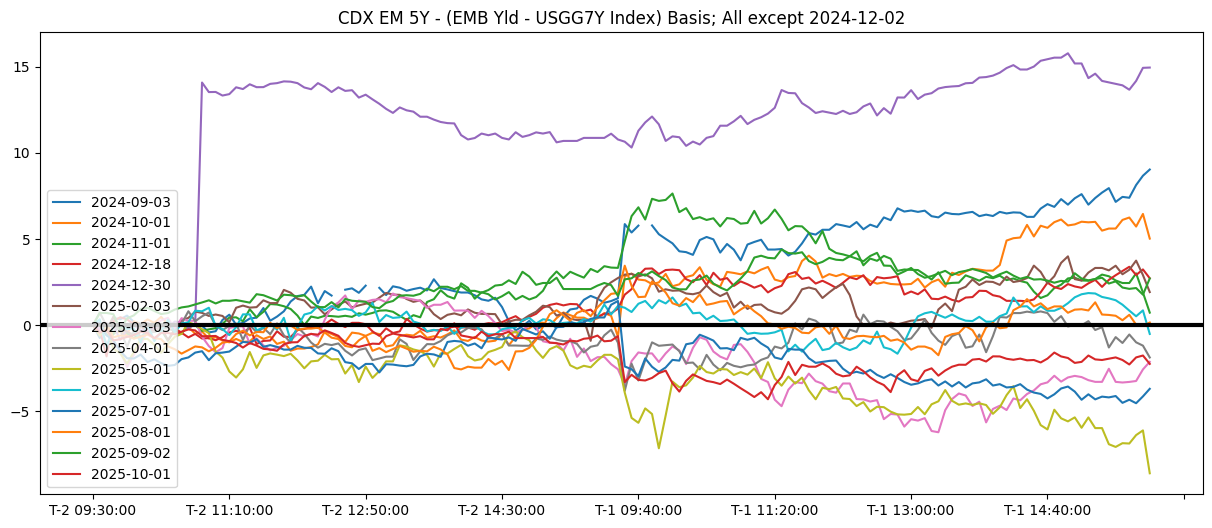

In [22]:
ty = all_t.iloc[:,-15:].drop(["2024-12-02"],axis=1).copy()
ty = ty - ty.iloc[0]
ty.plot(figsize=(15,6))
plt.title("CDX EM 5Y - (EMB Yld - USGG7Y Index) Basis; All except 2024-12-02")
plt.axhline(y=0,color="black",linewidth=3)
plt.legend(loc="lower left")
plt.show()

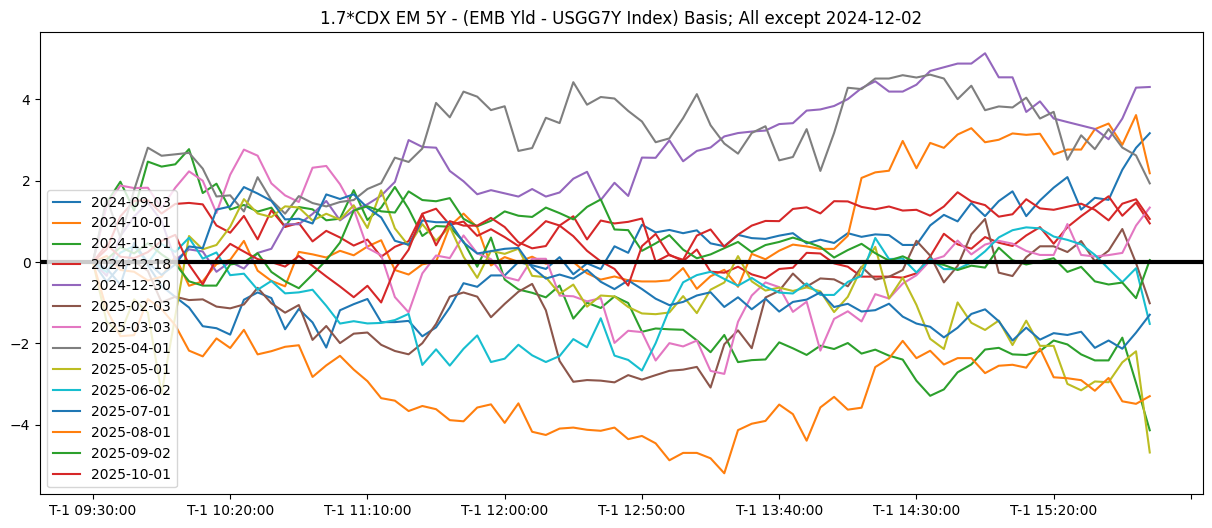

In [25]:
ty = all_t.iloc[78:,-15:].drop(["2024-12-02"],axis=1).copy()
ty = ty - ty.iloc[0]
ty.plot(figsize=(15,6))
# plt.title("CDX IG 5Y - (VCIT Yld - USGG5Y Index) Basis; All except 2024-12-02")
plt.title("1.7*CDX EM 5Y - (EMB Yld - USGG7Y Index) Basis; All except 2024-12-02")
plt.axhline(y=0,color="black",linewidth=3)
plt.legend(loc="lower left")
plt.show()

In [24]:
s = all_t.iloc[78:,:].copy()
s1 = (s.iloc[-1]-s.iloc[0]).dropna()#.median()
pos = [item for item in s1 if item>=0]
neg = [item for item in s1 if item<=0]
display(f"len of pos {len(pos)} and mean is {np.mean(pos)} and median is {np.median(pos)}")
display(f"len of neg {len(neg)} and mean is {np.mean(neg)} and median is {np.median(neg)}")
display(f"% time of up move is {(len(pos)*100 / (len(pos)+len(neg))):.1f}")
display(f"% time of down move is {(len(neg)*100 / (len(pos)+len(neg))):.1f}")

'len of pos 25 and mean is 2.283681435384823 and median is 1.978563634963848'

'len of neg 29 and mean is -4.433534103653634 and median is -3.3018520405300364'

'% time of up move is 46.3'

'% time of down move is 53.7'

In [2]:
# #ER Code
# ####################################################

# all_start_date = str((datetime.now()-timedelta(days=13*365+1)).strftime("%Y-%m-%d"))

# labels = {
#         "LQD Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_USDLIG_3M,JPM_IMPLIEDFUNDING_MID)",
#         "HYG Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_USDHY_3M,JPM_IMPLIEDFUNDING_MID)",
#         "IEAC Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_EURIG_3M,JPM_IMPLIEDFUNDING_MID)",
#         "IHYG Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_EURHY_3M,JPM_IMPLIEDFUNDING_MID)",
#         "Fed Fund": "FF",
#         "ER CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_RETURN)",
#         "ER CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_RETURN)",
#         "ER CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_RETURN)",
#         "ER CDX HY 10Y": "DB(CDS,TRAC-X,NAHY100UNF10ONRUN,JPM_RETURN)",
#         "ER CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_RETURN)",
#         "ER ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_UNFUNDED_INDEX)",
# }

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dq = df.copy()

# end_date = dq.index[-1]
# ####################################### BBG Data Acquisition

# securities = ['HYG US Equity','EMB US Equity','LQD US Equity','VCIT US Equity',
#               'IEAC LN Equity','IHYG LN EQUITY', 'BKLN US EQUITY', 'IBCN GR EQUITY',
#               'IEI US Equity','IEF US Equity']

# fields1 = ['YAS_MOD_DUR']
# df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields1)
# df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
# df1 = df.copy()

# #################################### Fixing Bad Data Point in YAS of IEI
# rolling_avg = df1['IEI DUR'].replace(0, np.nan).rolling(window=30, min_periods=1).mean()
# df1['IEI DUR'] = df1.apply(
#     lambda row: rolling_avg[row.name] if row['IEI DUR'] == 0.0 else row['IEI DUR'], axis=1
# )
# #################################### Fixing Bad Data Point in YAS of IEI

# securities = ['LT03TRUU INDEX','LT09TRUU INDEX','QW3I INDEX', 'LT03MD INDEX','LT09MD INDEX']
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields)
# df.columns = ['TR ' + item.split(' ')[0] for item in securities[:3]] + [item.split(' ')[0] + ' DUR' for item in securities[:2]]
# df1 = pd.concat([df,df1],axis=1)

# securities = ['HYG US Equity','EMB US Equity','LQD US Equity','VCIT US Equity',
#               'IEI US Equity','IEF US Equity', 'RSP US EQUITY', #'SPX INDEX',  'RTY INDEX',
#               'IBCN GR EQUITY',
#               'IEAC LN Equity','IHYG LN EQUITY', 'BKLN US EQUITY', 'IWM US EQUITY',
#               'GSCBHYEQ Index', 'GSCBIGEQ Index', 'SPY US EQUITY', 'EEM US EQUITY','IJH US EQUITY'
#              ]

# fields = ['TOT_RETURN_INDEX_GROSS_DVDS']
# df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields)
# df.columns = ['TR ' + item.split(' ')[0] for item in securities] 
# df1 = pd.concat([df,df1],axis=1)

# securities = ['QW3I INDEX']
# fields = ['MODIFIED_DURATION']
# df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields)
# df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
# df1 = pd.concat([df,df1],axis=1)

# # securities = ['SPXFP INDEX', 'RTYFPE INDEX','SX5EFSER Index']  ############## I want to calculate funding rate for spx, rty and sx5e separately
# # fields = ['PX_LAST']
# # df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields)
# # df.columns = ['ER SPX','ER RTY','ER SX5E']
# # df1 = pd.concat([df,df1],axis=1)

# securities = ['EURR002W Index']
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = all_start_date, end_date = end_date, flds = fields)
# df.columns = ['ECB Rate']
# df1 = pd.concat([df,df1],axis=1)

# bbg = df1.copy()
# dq.index = pd.to_datetime(dq.index)
# dq.index = dq.index.date
# bbg.index = pd.to_datetime(bbg.index)
# bbg.index = bbg.index.date

# data = pd.concat([dq,bbg],axis=1)
# data = data.sort_index()

# df_funding = data[[col for col in data.columns if ('Funding Sprd' in col)]+['Fed Fund']+['ECB Rate']]

# if np.isnan(df_funding.loc[df_funding.index[-1],'Fed Fund']):
#     df_funding.loc[df_funding.index[-1],'Fed Fund'] = df_funding.loc[df_funding.index[-2],'Fed Fund']

# for col in df_funding:
#     if col.endswith('Sprd'):
#         if col.split(' ')[0] in ['HYG','LQD']:
#             df_funding[f'Net Long {col.replace(" Sprd","")}'] = (df_funding['Fed Fund'] + df_funding[f'{col}']/100) + 0.25/100
#             df_funding[f'Net Short {col.replace(" Sprd","")}'] = (df_funding['Fed Fund'] + df_funding[f'{col}']/100) - 0.25/100
#         if col.split(' ')[0] in ['IHYG','IEAC']:
#             df_funding[f'Net Long {col.replace(" Sprd","")}'] = (df_funding['ECB Rate'] + df_funding[f'{col}']/100) + 0.25/100
#             df_funding[f'Net Short {col.replace(" Sprd","")}'] = (df_funding['ECB Rate'] + df_funding[f'{col}']/100) - 0.25/100

# df_funding['Net Long VCIT Funding'] = df_funding['Net Long LQD Funding']
# df_funding['Net Short VCIT Funding'] = df_funding['Net Short LQD Funding']

# for item in ['EMB','EEM']:
#     df_funding[f'Net Long {item} Funding'] = df_funding['Fed Fund'] + 0.5
#     df_funding[f'Net Short {item} Funding'] = df_funding['Fed Fund'] - 0.5

# for item in ['IEI', 'IEF', 'RSP', 'BKLN', 'GSCBHYEQ', 'GSCBIGEQ', 'SPX', 'RTY', 'SPY', 'IJH','IWM']:
#     df_funding[f'Net Long {item} Funding'] = df_funding['Fed Fund'] + 0.15
#     df_funding[f'Net Short {item} Funding'] = df_funding['Fed Fund'] - 0.15

# for item in ['IBCN','SX5E']:
#     df_funding[f'Net Long {item} Funding'] = df_funding['ECB Rate'] + 0.15
#     df_funding[f'Net Short {item} Funding'] = df_funding['ECB Rate'] - 0.15

# df_funding = df_funding[[col for col in df_funding.columns if col.startswith("Net")]]
# df_funding.index = pd.to_datetime(df_funding.index)
# df_funding = df_funding.resample('D').last()

# original_er_data = data[[col for col in data.columns if col.startswith("ER ")]]
# tr_data = data[[col for col in data.columns if col.startswith("TR ")]]
# ust = tr_data[['TR LT09TRUU']] # for using corr later
# tr_data = tr_data.iloc[:,:-3] #dropping LT03/09 and QW3I

# tr_data.index = pd.to_datetime(tr_data.index).date
# df_funding.index = pd.to_datetime(df_funding.index).date

# er_tr_data = pd.concat([tr_data,df_funding],axis=1)
# er_tr_data = er_tr_data.sort_index()
# # er_tr_data = er_tr_data.dropna()

# etfs = [col for col in er_tr_data.columns if col.startswith("TR ")]

# for item in etfs:
#     er_tr_data[item] = er_tr_data[item].diff()/er_tr_data[item].shift()

# er_tr_data['Date'] = pd.to_datetime(er_tr_data.index)
# er_tr_data['Days'] = (er_tr_data['Date'] - er_tr_data['Date'].shift()).dt.days
# # er_tr_data = er_tr_data.dropna()
# er_tr_data

# ############################################################### Funding Sprds
# funding = er_tr_data[[col for col in er_tr_data.columns if 'Funding' in col]].copy()
# x = er_tr_data[[col for col in er_tr_data.columns if 'Funding' in col]].copy()
# x = x.interpolate()
# x.to_excel("Funding Rates.xlsx")

# y = x.copy()
# y = round(y,2)
# y.to_excel("Funding Rates 2.xlsx")

# ###############################################################
# for item in etfs:
#     name = item.split(' ')[1]
#     er_tr_data[f'ER {name}'] = er_tr_data[item] - \
#                 (1/100)*(er_tr_data['Days']/360)*(0.5*(er_tr_data[f'Net Long {name} Funding'] + er_tr_data[f'Net Short {name} Funding']))


# er_tr_data = er_tr_data[[col for col in er_tr_data.columns if col.startswith("ER ")]]
# er_tr_data = (1+er_tr_data).cumprod()

# tr_data.index = pd.to_datetime(tr_data.index).date
# df_funding.index = pd.to_datetime(df_funding.index).date

# er_tr_data = pd.concat([tr_data,df_funding],axis=1)
# er_tr_data = er_tr_data.sort_index()
# # er_tr_data = er_tr_data.dropna()

# etfs = [col for col in er_tr_data.columns if col.startswith("TR ")]

# for item in etfs:
#     er_tr_data[item] = er_tr_data[item].diff()/er_tr_data[item].shift()

# er_tr_data['Date'] = pd.to_datetime(er_tr_data.index)
# er_tr_data['Days'] = (er_tr_data['Date'] - er_tr_data['Date'].shift()).dt.days
# # er_tr_data = er_tr_data.dropna()

# for item in etfs:
#     name = item.split(' ')[1]
#     er_tr_data[f'ER {name}'] = er_tr_data[item] - \
#                 (1/100)*(er_tr_data['Days']/360)*(0.5*(er_tr_data[f'Net Long {name} Funding'] + er_tr_data[f'Net Short {name} Funding']))

# er_tr_data = er_tr_data[[col for col in er_tr_data.columns if col.startswith("ER ")]]
# er_tr_data = (1+er_tr_data).cumprod()

# er_data = pd.concat([original_er_data,er_tr_data],axis=1)
# # er_data = er_data.dropna()
# # er_data.columns = er_data.columns.str.replace("ER SPX","ER ESA").str.replace("ER RTY","ER RTYA").str.replace("ER SX5E","ER VGA")
# er_data.columns = er_data.columns.str.replace("ER GSCBHYEQ","ER HY Eqty").str.replace("ER GSCBIGEQ","ER IG Eqty")

# securities = ['SPXFP INDEX', 'RTYFPE INDEX','SX5EFSER Index']
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = er_data.index[0], end_date = er_data.index[-1], flds = fields)
# df.columns = ['ER SPX','ER RTY','ER SX5E']
# er_data = pd.concat([er_data,df], axis=1)
# er_data = er_data.sort_index()

# er_data.to_csv("All ER.csv")

# ##############################################################

In [3]:
# all_start_date = str((datetime.now()-timedelta(days=13*365+1)).strftime("%Y-%m-%d"))

# labels = {
#     "CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_DUR)",
#     "CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_DUR)",
#     "ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_DUR)",
#     "ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_DUR)",
#     "ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_DUR)",
#     "ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_DUR)",
#     "ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_DUR)",
#     "ITRX XOVER 10Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/10y/JPM_DUR)"
# }

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dur = df.copy()
# dur.to_excel("DQ Dur.xlsx")

In [4]:
# all_start_date = str((datetime.now()-timedelta(days=13*365+1)).strftime("%Y-%m-%d"))

# labels = {
#     "CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_CDSSPREAD_MID)",
#     "CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_CDSSPREAD_MID)",
#     "CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_CLEAN_MID)",
#     "ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_CDSSPREAD_MID)",
#     "ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_CDSSPREAD_MID)",
#     "ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_CDSSPREAD_MID)",
#     "ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_CDSSPREAD_MID)",
#     "ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_CDSSPREAD_MID)",
#     "ITRX XOVER 10Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/10y/JPM_CDSSPREAD_MID)",
#     "CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_CLEAN_MID)",
# }

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dur = df.copy()
# dur.to_excel("DQ Ref Levels_PX_Sprd.xlsx")

In [5]:
# df_backup = pd.read_parquet("Clean 1min data.parquet")
# df = pd.read_excel("IJH Data.xlsx")
# all_x = None
# for i in range(int(len(df.columns)))[::2]:
#     x = df.iloc[:,i:i+2]
#     x.columns = ["Date","IJH"]
#     all_x = pd.concat([all_x, x])
# all_x = all_x.dropna()
# all_x = all_x.drop_duplicates()
# all_x["Date"] = pd.to_datetime(all_x["Date"])
# all_x = all_x.set_index("Date")
# all_x = all_x.resample("1min").last().ffill().copy()
# all_x = all_x[all_x.index.isin(df_backup.index)].copy()

# df = pd.concat([df_backup, all_x],axis=1)
# df = df[list(set(df.columns))].copy()
# df.to_parquet("Clean 1min data.parquet")

In [6]:
dict_map = {
    # product type, start time, end time, carry (%), trades on sprd, slippage (bps or $),
    # fixed commission, notional (if selected as Y; moved to model up look up!), BBG ticker
    'CDX IG 5Y': ['CDX', '07:45:00', '16:30:00', 1, 'Yes', 0.15, 300, "CDX IG CDSI GEN 5Y CORP"],
    'CDX IG 10Y': ['CDX', '07:45:00', '16:30:00', 1, 'Yes', 0.3, 300, "CDX IG CDSI GEN 10Y CORP"],
    'CDX HY 5Y': ['CDX', '07:45:00', '16:30:00', 5, 'No', 0.02, 300, "CDX HY CDSI GEN 5Y CORP"],
    'SPX': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "SPX INDEX"],
    'SPY': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "SPY US EQUITY"],
    'RSP': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "RSP US INDEX"],    
    'RTY': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "RTY INDEX"],
    'IG Eqty': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "GSCBIGEQ Index"],
    'HY Eqty': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "GSCBHYEQ Index"],
    'ITRX MAIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 300, "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX XOVER 5Y': ['CDX', '03:30:00', '11:59:00', 5, 'Yes', 0.15, 300, "ITRX XOVER CDSI GEN 5Y CORP"],
    
    'VIX': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "VIX INDEX"],
    'V2X': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, "V2X INDEX"],
    'SX5E': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, "SX5E INDEX"],
    'ITRX SNRFIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 300, "SNRFIN CDSI GEN 5Y CORP"],
    'ITRX SUBFIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 300, "SUBFIN CDSI GEN 5Y CORP"],
    'CDX EM 5Y': ['CDX', '07:45:00', '16:30:00', 1, 'No', 0.02, 300, "CDX EM CDSI GEN 5Y CORP"],

    'HYG': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "HYG US EQUITY"],
    'EMB': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "EMB US EQUITY"],
    'EEM': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "EEM US EQUITY"],
    'VCIT': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "VCIT US EQUITY"],
    'LQD': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "LQD US EQUITY"],
    'IEI': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "IEI US EQUITY"],
    'IEF': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "IEF US EQUITY"],
    'IWM': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "IWM US EQUITY"],
    'IJH': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, "IJH US EQUITY"],
}

# er_data = pd.read_csv("All ER.csv", index_col=0, parse_dates=True)
# er_data.columns = [item.split(" ",1)[1] for item in er_data.columns]

# df_backup = pd.read_parquet("Clean 1min data.parquet")

# ##################################################################

# bbg_tickers = [dict_map[item][7] for item in dict_map.keys()]
# reverse_dict = dict(zip(bbg_tickers, list(dict_map.keys())))
# bbg_data = blp.bdh(tickers = bbg_tickers, flds='px_last', start_date='2017-01-01')
# bbg_data.columns = bbg_tickers
# bbg_data.index = pd.to_datetime(bbg_data.index)
# bbg_data.columns = [reverse_dict[item] for item in bbg_data.columns]
# ref = pd.read_excel("DQ Ref Levels_PX_Sprd.xlsx", index_col=0, parse_dates=True)

# for col in ref.columns:
#     bbg_data[col] = ref[col]

# bbg_data1 = bbg_data.resample("1min").last().ffill().copy()
# bbg_data1.columns = [item +'_bbg_px' for item in bbg_data1.columns]

# bbg_data2 = bbg_data.shift().resample("1min").last().ffill().copy()
# bbg_data2.columns = [item +'_bbg_px_2' for item in bbg_data2.columns]

# ##################################################################

# dur = pd.read_excel("DQ Dur.xlsx",index_col=0, parse_dates=True)
# dur = dur.shift().resample("1min").last().ffill().copy()  ############ yesterday's duration we take .. we have shifted it here
# dur.columns = [item + '_dq_dur' for item in dur.columns]

# df = df_backup.copy()
# er = er_data.copy()
# er.columns = [item + '_dq_ER' for item in er.columns]
# er = er.resample("1min").last().ffill().copy()

# er2 = er_data.shift().copy()
# er2.columns = [item + '_dq_ER_2' for item in er2.columns]
# er2 = er2.resample("1min").last().ffill().copy()

# ##################################################################
# #### V. V. Imp: the dq close is as of 5PM and with bbg_data only till 4PM we don't really 'see' the BBG ER series match the DQ series

# intraday_tr_data = None

# for col in df.columns:
#     # col = "IEI"
#     if dict_map[col][4] == 'Yes':
#         x = pd.concat([df[[col]], er[[f'{col}_dq_ER']], er2[[f'{col}_dq_ER_2']], bbg_data1[[f'{col}_bbg_px']], bbg_data2[[f'{col}_bbg_px_2']],
#             dur[[f'{col}_dq_dur']]], axis=1).sort_index().dropna().copy()
#         x['TR Change'] = (x[f'{col}_dq_ER'] / x[f'{col}_dq_ER_2'] - 1)
#         x['d-o-d sprd pnl'] = (-1) * (x[f'{col}_dq_dur']) * (x[f'{col}_bbg_px'] - x[f'{col}_bbg_px_2']) * 10**(-4)
#         x['intraday sprd pnl'] = (-1) * (x[f'{col}_dq_dur']) * (x[col] - x[f'{col}_bbg_px_2']) * 10**(-4)
#         x['Calculated TR Change'] = x['TR Change'] - x['d-o-d sprd pnl'] + x['intraday sprd pnl']
#         x['Actual TR Series'] = (1 + x['Calculated TR Change']) * x[f'{col}_dq_ER_2']
#         x = x[['Actual TR Series']].copy()
#         x.columns = [col]
#     else:
#         x = pd.concat([df[[col]], er[[f'{col}_dq_ER']], er2[[f'{col}_dq_ER_2']], bbg_data1[[f'{col}_bbg_px']], bbg_data2[[f'{col}_bbg_px_2']],
#             ], axis=1).sort_index().dropna().copy()
#         x['TR Change'] = (x[f'{col}_dq_ER'] / x[f'{col}_dq_ER_2'] - 1)
#         if col in ["CDX HY 5Y", "CDX HY 10Y", "CDX EM 5Y"]:
#             x['d-o-d px pnl'] = (x[f'{col}_bbg_px'] - x[f'{col}_bbg_px_2']) * 10**(-2)
#             x['intraday px pnl'] = (x[col] - x[f'{col}_bbg_px_2']) * 10**(-2)
#         else:  ### it is an etf
#             x['d-o-d px pnl'] = (x[f'{col}_bbg_px']/ x[f'{col}_bbg_px_2'] - 1)
#             x['intraday px pnl'] = (x[col] / x[f'{col}_bbg_px_2'] - 1)
#         x['Calculated TR Change'] = x['TR Change'] - x['d-o-d px pnl'] + x['intraday px pnl']
#         x['Actual TR Series'] = (1 + x['Calculated TR Change']) * x[f'{col}_dq_ER_2']
#         x = x[['Actual TR Series']].copy()
#         x.columns = [col]
#     intraday_tr_data = pd.concat([intraday_tr_data, x], axis=1)

# intraday_tr_data.to_parquet("1min ER series.parquet")

In [7]:
z_score_method = "Rtn" #"Rtn"
diff_period_list = [1]

models_list = [ 
    # model_Y, model_X (specify as a list) ### We trade these
    # zscore_Y, zscore_X (specify as a list) ### We use these only for generating the zscore; names are taken from BBG datafile

    # ['CDX HY 5Y', ['HYG','IEI'], 'CDX HY 5Y', ['HYG','IEI'], 7*10**6],
    # ['CDX EM 5Y', ['EMB','IEF'], 'CDX EM 5Y', ['EMB','IEF'], 9*10**6],
    # ['CDX IG 5Y', ['VCIT','IEF'], 'CDX IG 5Y', ['VCIT','IEF'], 25*10**6],
    
    # ['CDX IG 10Y', ['LQD','IEF'], 'CDX IG 10Y', ['LQD','IEF'], 14*10**6],
    ['CDX IG 5Y', ['SPX'],'CDX IG 5Y', ['SPX'],28*10**6],
    # # ['CDX IG 5Y', ['RSP'],'CDX IG 5Y', ['RSP'],28*10**6],
    # ['CDX IG 5Y', ['IWM'],'CDX IG 5Y', ['IWM'],28*10**6],
    # ['CDX IG 5Y', ['IJH'],'CDX IG 5Y', ['IJH'],28*10**6],
    # # ['CDX IG 5Y', ['IG Eqty'],'CDX IG 5Y', ['IG Eqty'],28*10**6],
    
    # ['CDX HY 5Y', ['SPX'],'CDX HY 5Y', ['SPX'],6*10**6],
    # # ['CDX HY 5Y', ['RTY'],'CDX HY 5Y', ['RTY'],6*10**6],
    # # ['CDX HY 5Y', ['RSP'],'CDX HY 5Y', ['RSP'],6*10**6],
    # ['CDX HY 5Y', ['IWM'],'CDX HY 5Y', ['IWM'],6*10**6],
    # ['CDX HY 5Y', ['IJH'],'CDX HY 5Y', ['IJH'],6*10**6],
    # # ['CDX HY 5Y', ['HY Eqty'],'CDX HY 5Y', ['HY Eqty'],6*10**6],
    
    # # ['ITRX MAIN 5Y', ['SX5E'],'ITRX MAIN 5Y', ['SX5E'], 28*10**6],
    # # ['ITRX XOVER 5Y', ['SX5E'],'ITRX XOVER 5Y', ['SX5E'], 6*10**6],
    # # ['ITRX XOVER 5Y', ['SPX'],'ITRX XOVER 5Y', ['SPX'], 6*10**6],
    # # ['CDX IG 5Y', ['ITRX MAIN 5Y'],'CDX IG 5Y', ['ITRX MAIN 5Y'], 50*10**6],
    
    # # ['CDX HY 5Y', ['ITRX XOVER 5Y'],'CDX HY 5Y', ['ITRX XOVER 5Y'], 8*10**6],
    # # ['ITRX MAIN 5Y', ['ITRX XOVER 5Y'],'ITRX MAIN 5Y', ['ITRX XOVER 5Y'], 66*10**6],
    # # ['CDX IG 5Y', ['CDX HY 5Y'],'CDX IG 5Y', ['CDX HY 5Y'], 74*10**6],
    
    # # ['CDX IG 5Y', ['CDX EM 5Y'],'CDX IG 5Y', ['CDX EM 5Y'], 22*10**6],
    # # ['CDX EM 5Y', ['CDX HY 5Y'],'CDX EM 5Y', ['CDX HY 5Y'], 8*10**6],
    # # ['ITRX MAIN 5Y', ['CDX EM 5Y'],'ITRX MAIN 5Y', ['CDX EM 5Y'], 22*10**6],
    # # ['CDX EM 5Y', ['ITRX XOVER 5Y'],'CDX EM 5Y', ['ITRX XOVER 5Y'], 6*10**6],

    # # ['CDX IG 5Y', ['SPY'],'CDX IG 5Y', ['SPY'],28*10**6],
    # # ['CDX HY 5Y', ['SPY'],'CDX HY 5Y', ['SPY'],6*10**6],
    
    # # ['EEM', ['EMB'], 'EEM', ['EMB'], 1*10**6],
    # # ['CDX EM 5Y', ['EEM'], 'CDX EM 5Y', ['EEM'], 6*10**6],
]

In [8]:
dict_models = {
    1 : ["Intraday",252,252,'A (Intraday; 12M)'],
    # 2 : ["Intraday",315,315,'B (Intraday; 15M)'],
    # 3 : ["Intraday",378,378,'C (Intraday; 18M)'],
    # 4 : ["Intraday",504,504,'D (Intraday; 24M)'],
}

sampling_freq = '10min'

for global_model in models_list:
    for model_num in list(dict_models.keys()):
        for trade_btdf_direction in ['Long','Short','Long/Short']:
            for info in ['$pnl','$pnl/trade','SR','Hit Ratio','trades','days/trade','max DD']:
                globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_{info}'] = pd.DataFrame()
                globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_{info}'].index.name = 'Entry'
                globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_{info}'].columns.name = info

fund_rates = pd.read_excel("Funding Rates 2.xlsx")
fund_rates.columns = ['Date'] + list(fund_rates.columns)[1:]
fund_rates['Date'] = pd.to_datetime(fund_rates['Date'])
fund_rates = fund_rates.set_index('Date')
fund_rates.columns = fund_rates.columns.str.replace("GSCB","").str.replace("EQ "," Eqty ").str.replace(" Funding","").str.replace("Net ","")
etfs = list(set([item.split(" ",1)[1] for item in fund_rates.columns]))

def apply_funding(df_funding_update, variable_item):
    if f'Long {variable_item}' in fund_rates.columns:
        rate = fund_rates[[f'Long {variable_item}',f'Short {variable_item}']].dropna().resample("1min").last().bfill().copy()
        df_funding_update = pd.concat([df_funding_update, rate],axis=1)
        df_funding_update = df_funding_update.dropna()
        df_funding_update.columns = list(df_funding_update.columns)[:-2] + ['Long_Funding','Short_Funding']
        df_funding_update['T'] = df_funding_update.index.date
        df_funding_update['T-1'] = [np.nan] + list(df_funding_update.index[:-1].date)
        df_funding_update['Funding_Date'] = df_funding_update.apply(lambda row: 'New Day' if row['T'] != row['T-1'] else 'Same Day', axis=1)
        df_funding_update['Long_Funding'] = df_funding_update.apply(lambda row: row["Long_Funding"] if row["Funding_Date"] == "New Day" else 0,axis=1)
        df_funding_update['Short_Funding'] = df_funding_update.apply(lambda row: row["Short_Funding"] if row["Funding_Date"] == "New Day" else 0,axis=1)
        df_funding_update = df_funding_update.drop(['Funding_Date'],axis=1)
        # df_funding_update['Funding'] = 0.5*(df_funding_update['Long_Funding'] + df_funding_update['Short_Funding'])
        df_funding_update['T-1'] = [item.date() for item in pd.to_datetime(df_funding_update['T-1'])]
        df_funding_update['T-1'].iloc[0] = df_funding_update['T'].iloc[0]
        df_funding_update['Long Funding P/L'] = [item.days for item in (df_funding_update['T'] - df_funding_update['T-1'])]
        df_funding_update['Long Funding P/L'] *= (df_funding_update['Long_Funding'] / 100) * (1/360) * abs(df_funding_update['Notional'])
        df_funding_update['Short Funding P/L'] = [item.days for item in (df_funding_update['T'] - df_funding_update['T-1'])]
        df_funding_update['Short Funding P/L'] *= (df_funding_update['Short_Funding'] / 100) * (1/360) * abs(df_funding_update['Notional'])
        df_funding_update = df_funding_update.drop(['T','T-1','Long_Funding','Short_Funding'],axis=1)
    else:
        df_funding_update['Long Funding P/L'] = [0.0] * len(df_funding_update)
        df_funding_update['Short Funding P/L'] = [0.0] * len(df_funding_update)

    return df_funding_update.copy()

In [ ]:
# bbg_px = pd.read_parquet("Clean 1min data.parquet")
bbg_px = pd.read_excel("10min data with EUv8.xlsx", index_col=0, parse_dates=True)

if z_score_method == "PX":
    zscore_calc_df = bbg_px.copy()
elif z_score_method == "Rtn":
    zscore_calc_df = pd.read_parquet("1min ER series.parquet")   
    # zscore_calc_df = pd.read_parquet("Intraday 1min ER series.parquet")

for global_model in models_list:
    for model_num in list(dict_models.keys()):  

        # global_model = models_list[0]
        # model_num = list(dict_models.keys())[0]
        
        model_Y = global_model[0]
        model_X = global_model[1]
        zscore_Y = global_model[2]
        zscore_X = global_model[3]
        backtest_start_date = pd.to_datetime('2017-03-01')
        notional_to_use = global_model[4]
        
        zscore_vars = [model_Y, zscore_Y] + model_X + zscore_X
        
        zscore_vars = list(set(zscore_vars))
        zscore_vars_start_time = max([dict_map[item][1] for item in zscore_vars])
        zscore_vars_end_time = min([dict_map[item][2] for item in zscore_vars])
        
        ################################## Beta Calculation
        if len(model_X) == 1:
            er_Y = f'ER {model_Y}'
            er_X = f'ER {model_X[0]}'
            er_data = pd.read_csv("All ER.csv")
            er_data.columns = ['Date'] + list(er_data.columns)[1:]
            er_data['Date'] = pd.to_datetime(er_data['Date'])
            er_data = er_data.set_index('Date')
            er_data = er_data.sort_index()
            beta = er_data[[er_Y, er_X]].dropna()
            beta = beta.resample('W').last()
            beta = np.log(beta)
            beta = beta.diff().dropna()
            beta['Beta1'] = [np.nan] * len(beta)
            beta['Beta2'] = [np.nan] * len(beta)
            
            for i in range(len(beta)-24+1):
                reg_X = beta[er_X].iloc[i:i+24]
                reg_Y = beta[er_Y].iloc[i:i+24]
                model = sm.OLS(reg_Y, sm.add_constant(reg_X)).fit() 
                beta.iloc[i+23,2] = model.params.iloc[1]
            
                model = sm.OLS(reg_X, sm.add_constant(reg_Y)).fit() 
                beta.iloc[i+23,3] = model.params.iloc[1]
            
            beta['Beta1'] = beta['Beta1'].rolling(104).mean()
            beta['Beta2'] = beta['Beta2'].rolling(104).mean()
            beta['Beta'] = 0.5*(beta['Beta1'] + 1/ beta['Beta2'])
            beta = beta[['Beta']].dropna()
            # beta = pd.read_excel("igspx_beta_1ymodel.xlsx", index_col=0, parse_dates=True)
        
        else:
            
            b1 = pd.read_csv("All Basis Trade Betas.csv")
            b1.columns = ['Date'] + list(b1.columns)[1:]
            b1 = b1.set_index('Date')
            beta = b1[[f'{model_Y}_{model_X[0]}_{model_X[1]}']]
            beta.columns = ['Beta']
            beta['Coef1'] = beta['Beta'].apply(lambda x: eval(x)[0])
            beta['Coef2'] = beta['Beta'].apply(lambda x: eval(x)[1])
            beta.index = pd.to_datetime(beta.index)
            
        beta = beta.resample("1min").first().ffill()
        
        ################################## BBG DataFile Intraday
        # df = pd.read_excel("10min data with EUv7.xlsx")
        # df['Date'] = pd.to_datetime(df['Date'])
        # df = df.set_index('Date')
        # df = df.sort_index()
        df = zscore_calc_df.copy()
        
        zscore_df = df[zscore_vars].between_time(zscore_vars_start_time, zscore_vars_end_time).dropna().copy()
        zscore_df = zscore_df.resample("10min",offset="5min").last().dropna().copy()
        zscore_df = zscore_df.between_time(zscore_vars_start_time, zscore_vars_end_time).dropna().copy()
        bbg_datafile = zscore_df.copy()
        
        sampling_multiplier = len(set(list(bbg_datafile.index.time)))
        
        ################################## ZScore Calculation Start : Convert Sprd to PX series
        
        df = pd.read_excel("All DQ Duration.xlsx")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.sort_index()
        df.columns = df.columns.str.replace(" Dur","")
        df = df.resample("1min").first().ffill().dropna()
        dq_dur = df.copy()
        
        zscore_df1 = zscore_df.copy()

        if z_score_method == "PX":
            for col in zscore_df1.columns:
                if col in dq_dur.columns:
                    zscore_df1[f'{col} Dur'] = dq_dur[col]
                    zscore_df1[f'{col} Dur'] = zscore_df1[f'{col} Dur'].shift(1)
                    zscore_df1[f'Diff {col}'] = zscore_df1[col].diff()
                    zscore_df1 = zscore_df1.dropna()
                    zscore_df1[f'{col} Daily PX Change'] = -1 * zscore_df1[f'Diff {col}'] * zscore_df1[f'{col} Dur'] *10**(-4)
                    zscore_df1[f'{col} Sum PX'] = zscore_df1[f'{col} Daily PX Change'].cumsum()
                    zscore_df1[col] = zscore_df1[f'{col} Sum PX']
                    zscore_df1 = zscore_df1[zscore_df.columns].copy()
        
        ################################## ZScore Calculation: Differencing and converting to ZScores
        
        zscore_df = zscore_df1[zscore_df1.index >= backtest_start_date].copy()
        
        col_list = zscore_df.columns
        for period in diff_period_list:
            for col in col_list:
                zscore_df[f'{col}_{period}W'] = zscore_df[col].diff(sampling_multiplier*5*period)
                # zscore_df[f'{col}_{period}W'] = zscore_df[col].diff(sampling_multiplier*period)  ##### Daily
        
        model_lookback = sampling_multiplier*dict_models[model_num][1]
        model_lookback_res = sampling_multiplier*dict_models[model_num][2]
        zscore_df = zscore_df.dropna().copy()
        zscore_df2 = zscore_df.copy()

        for period in diff_period_list:
            for i in range(len(zscore_df) - model_lookback + 1):
        
                reg_Y = zscore_df[[f'{zscore_Y}_{period}W']].iloc[i:i+model_lookback]
                reg_X = zscore_df[[item + f"_{period}W" for item in zscore_X]].iloc[i:i+model_lookback]

                model = sm.OLS(reg_Y,sm.add_constant(reg_X)).fit()
                x = (model.resid - model.resid.rolling(model_lookback_res).mean())/model.resid.rolling(model_lookback_res).std()
                zscore_df.loc[zscore_df.index[i+model_lookback-1],f'{period}W_ZScore'] = x.iloc[-1]

        zscore_df['Avg. ZScore'] = zscore_df[[col for col in zscore_df.columns if col.endswith("_ZScore")]].mean(axis=1)
        zscore_df = zscore_df[['Avg. ZScore']]
        bt_df = pd.concat([bbg_datafile[[model_Y] + model_X],zscore_df],axis=1).dropna()   
        
        #############################################

        if z_score_method == "Rtn":
            bbg_data = bbg_px.copy()
            bbg_data = bbg_data[[model_Y] + model_X].dropna().copy()
            bbg_data = bbg_data.resample("10min", offset="5min").last().ffill().copy()
            bbg_data = bbg_data[bbg_data.index.isin(bt_df.index)]
            for col in bbg_data.columns:
                bt_df[col] = bbg_data[col]
            
        ############################# If dur > 0 => trades on sprd ; if dur = 0 => cdx trades on px ; if dur = -1 => eq. product trades on px
        for col in bt_df.columns:
            if col != "Avg. ZScore":
                if col in dq_dur.columns:
                    bt_df[f'{col} Dur'] = dq_dur[dq_dur.index.isin(bt_df.index)][col]
                elif dict_map[col][0] == 'CDX':
                    bt_df[f'{col} Dur'] = [0.0] * len(bt_df)
                elif dict_map[col][0] == 'Eq':
                    bt_df[f'{col} Dur'] = [-1.0] * len(bt_df)
        bt_df['volume'] = [0.0] * len(bt_df)
        
        bt_df = bt_df[bt_df.index >= pd.to_datetime("2021-07-01")].dropna()
        bt_df = bt_df[bt_df.index <= pd.to_datetime("2025-04-26")].dropna()
        
        ############################# Backtrader dfs
        bt_df = pd.concat([bt_df,beta],axis=1).dropna()
        bt_df.columns = bt_df.columns.str.replace("Beta","Notional")
        
        if len(model_X) == 1:
            dfy = bt_df[[model_Y,f'{model_Y} Dur','Avg. ZScore','Notional','volume']].dropna().copy()
            dfy.columns = dfy.columns.str.replace("Avg. ZScore","Signal").str.replace(f'{model_Y} Dur','Dur').str.replace(model_Y,"close")
            dfy['Notional'] = notional_to_use
            
            dfx = bt_df[[model_X[0],f'{model_X[0]} Dur','Avg. ZScore','Notional','volume']].dropna().copy()
            dfx.columns = dfx.columns.str.replace("Avg. ZScore","Signal").str.replace(f'{model_X[0]} Dur','Dur').str.replace(model_X[0],"close")
            dfx['Notional'] *= notional_to_use
            dfx['Signal'] *= -1    
        
            dfy = apply_funding(dfy.copy(), model_Y)
            dfx = apply_funding(dfx.copy(), model_X[0])
        
        if len(model_X) == 2:
            
            dfy = bt_df[[model_Y,f'{model_Y} Dur','Avg. ZScore','Notional','volume']].dropna().copy()
            dfy.columns = dfy.columns.str.replace("Avg. ZScore","Signal").str.replace(f'{model_Y} Dur','Dur').str.replace(model_Y,"close")
            dfy['Notional'] = notional_to_use
            
            dfx = bt_df[[model_X[0],f'{model_X[0]} Dur','Avg. ZScore','Notional','volume']].dropna().copy()
            dfx.columns = dfx.columns.str.replace("Avg. ZScore","Signal").str.replace(f'{model_X[0]} Dur','Dur').str.replace(model_X[0],"close")
            dfx['Notional'] = notional_to_use * bt_df['Coef1']
            dfx['Signal'] *= -1   ############################ in basis only hyg px we sell when we buy the residuals so only this will be inverted
            
            dfx1 = bt_df[[model_X[1],f'{model_X[1]} Dur','Avg. ZScore','Notional','volume']].dropna().copy()
            dfx1.columns = dfx1.columns.str.replace("Avg. ZScore","Signal").str.replace(f'{model_X[1]} Dur','Dur').str.replace(model_X[1],"close")
            dfx1['Notional'] = notional_to_use * bt_df['Coef2']
        
            dfy = apply_funding(dfy.copy(), model_Y)
            dfx = apply_funding(dfx.copy(), model_X[0])
            dfx1 = apply_funding(dfx1.copy(), model_X[1])
        
        
        class MyData(bt.feeds.PandasData):
            lines = ('signal', 'notional', 'dur', 'long_funding', 'short_funding')
            params = (('signal', 'Signal'), ('notional', 'Notional'), 
                      ('dur', 'Dur'), ('long_funding', 'Long Funding P/L'), ('short_funding', 'Short Funding P/L'))
        
        class FixedComm(bt.CommInfoBase):
            params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
            def _getcommission(self, size, price, pseudoexec):
                return self.p.commission
        
        class TStrategy(bt.Strategy):
            params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, carry = 0, product = 'Untitled')
            
            def __init__(self):
                self.portfolio_values = []
                self.entry_date = None
                self.daily_pnl = []
                self.roll_trades = []
                self.carry = []
                self.roll_carry = []
                
                self.funding = []
                self.funding_carry = []
                self.funding_direction = None
                self.entry_bar_funding = None
                
                self.trade_direction = []
                
                self.scatter_plot_trade_pnl = []
                self.scatter_plot_trade_init_len = None
                
                self.carry_direction = 0
                self.logs = []
        
            def log(self, txt):
                dt = self.datas[0].datetime.datetime(0)
                print(f'{dt} - {txt}')
                self.logs.append([dt.isoformat(), txt])
        
            def notify_trade(self, trade):            
                if trade.isclosed:            
                    current_date = self.datas[0].datetime.datetime(-1)
                    
                    self.trade_direction.append((current_date, self.funding_direction if self.p.product == model_Y else None)) 
                    #### Y determines the long/short direction
                    
                    
                    ######################################## Calculating carry for all trades
                    self.daily_pnl.append((current_date, trade.pnlcomm))
        
                    if self.carry_direction > 0 : 
                        self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                          date()).days*(1/360)*self.p.carry*(1/100)*self.datas[0].notional[0]))
                    elif self.carry_direction < 0 :
                        self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                         date()).days*(1/360)*self.p.carry*(1/100)*self.datas[0].notional[0]))
                    
                    ######################################## Calculating funding for all trades
                    bars_active = len(self) - self.entry_bar_funding - 1
                    
                    if self.funding_direction == "Long":
                        values = [self.datas[0].long_funding[-i] for i in range(bars_active)]
                        rolling_sum = -1*sum(values)  ############ We pay the long funding
                    
                    elif self.funding_direction == "Short":
                        values = [self.datas[0].short_funding[-i] for i in range(bars_active)]
                        rolling_sum = sum(values)  ############ We earn the short funding
                        
                    self.funding.append((current_date, rolling_sum))
        
                    
                    p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
                    p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
                    p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
                    p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
                    periods = [p1, p2, p3, p4]
                    
                    ######################################## Calculating carry for roll trades separately
                    
                    for i in range(len(periods)):
                        p = periods[i]
                        if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                            self.roll_trades.append((current_date, trade.pnlcomm))
                            if self.carry_direction > 0:
                                self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                                               date()).days*(1/360)*self.p.carry*(1/100)*self.datas[0].notional[0]))
                            elif self.carry_direction < 0:
                                self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                              date()).days*(1/360)*self.p.carry*(1/100)*self.datas[0].notional[0]))
        
                            self.funding_carry.append((current_date, rolling_sum))
                            
                            break
                    
                    ################################################# All trades
                    
                    # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
                    self.carry_direction = 0
        
            # def notify_order(self, order):
            #     if order.status in [order.Completed]:
            #         if order.isbuy():
            #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
            #         else:
            #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
        
            def next(self):
                self.broker.set_coc(self.p.cheat_on_close)
                # val = None
                self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
                
                z = self.datas[0].signal[0]
                px = self.datas[0].close[0]        
                pos = self.getposition(self.datas[0]).size
        
                # self.log(f'PX: {px}, ZScore: {z:.3f}, Notional: {self.datas[0].notional[0]:.0f}, Dur: {self.datas[0].dur[0]:.4f} '
                #          f'Pos: {pos:.2f}, Long Funding $: {self.datas[0].long_funding[0]:.2f}, Short Funding $: {self.datas[0].short_funding[0]:.2f} '
                #          f'Eqty (000): {(self.broker.getvalue()-1e12)*10**(-3):.2f}')
                
                if pos == 0:                
                    if z < -self.p.entry_zscore:
                        self.scatter_plot_trade_init_len = len(self)
                        self.entry_date = self.datas[0].datetime.datetime(0)
        
                        if self.datas[0].dur[0] == -1:
                            self.buy(data = self.data, size = self.datas[0].notional[0]/px)
                        elif self.datas[0].dur[0] == 0.0:
                            self.buy(data=self.datas[0], size = (self.datas[0].notional[0] / 100))
                        elif self.datas[0].dur[0] > 0.0:
                            self.sell(data=self.data, size = (self.datas[0].notional[0])*10**(-4)*self.datas[0].dur[0])
        
                        self.carry_direction = 1
                        self.entry_bar_funding = len(self)
                        self.funding_direction = "Long"
        
                    elif z > self.p.entry_zscore:
                        self.scatter_plot_trade_init_len = len(self)
                        self.entry_date = self.datas[0].datetime.datetime(0)
        
                        if self.datas[0].dur[0] == -1:
                            self.sell(data = self.data, size = self.datas[0].notional[0]/px)
                        elif self.datas[0].dur[0] == 0.0:
                            self.sell(data=self.datas[0], size = (self.datas[0].notional[0] / 100))
                        elif self.datas[0].dur[0] > 0.0:
                            self.buy(data=self.data, size = (self.datas[0].notional[0])*10**(-4)*self.datas[0].dur[0])
        
                        self.carry_direction = -1
                        self.entry_bar_funding = len(self)
                        self.funding_direction = "Short"
                        
                else:
                        if self.datas[0].dur[0] <= 0.0: ######## Equity & CDX HY
                            if ((pos > 0 and z > -self.p.exit_zscore) or (pos < 0 and z < self.p.exit_zscore)):
                                self.close(data=self.datas[0])
                                self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                                    datetime(0), len(self) - self.scatter_plot_trade_init_len))
                        
                        elif self.datas[0].dur[0] > 0.0: ######## CDX IG
                            if ((pos < 0 and z > -self.p.exit_zscore) or (pos > 0 and z < self.p.exit_zscore)):
                                self.close(data=self.datas[0])
                                self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                                    datetime(0), len(self) - self.scatter_plot_trade_init_len))
        
        
            # def stop(self):
            #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
            #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
            #         writer = csv.writer(f)
            #         writer.writerow(['Date','Message'])
            #         writer.writerows(self.logs)
        
        for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
            for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
                if strategy_zscore_entry > strategy_zscore_exit:
        
                    cerebro1 = bt.Cerebro()
                    cerebro1.addstrategy(TStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit,\
                                         carry = dict_map[model_Y][3], product = model_Y)
                    
                    cerebro1.broker.setcash(1e12)
                    feed1 = MyData(dataname=dfy.copy(), timeframe=bt.TimeFrame.Minutes)
                    cerebro1.adddata(feed1)
                    cerebro1.broker.set_slippage_fixed(fixed=dict_map[model_Y][5], slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                    cerebro1.broker.setcommission(margin=0.00001, mult=1)
                    cerebro1.broker.addcommissioninfo(FixedComm(commission=dict_map[model_Y][6]))
                    cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                    results1 = cerebro1.run()
                    
                    cerebro2 = bt.Cerebro()
                    cerebro2.addstrategy(TStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit,\
                                         carry = dict_map[model_X[0]][3], product = model_X[0])
                    cerebro2.broker.setcash(1e12)
                    feed2 = MyData(dataname=dfx.copy(), timeframe=bt.TimeFrame.Minutes)
                    cerebro2.adddata(feed2)
                    cerebro2.broker.set_slippage_fixed(fixed=dict_map[model_X[0]][5], slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
                    cerebro2.broker.setcommission(margin=0.00001, mult=1)
                    cerebro1.broker.addcommissioninfo(FixedComm(commission=dict_map[model_X[0]][6]))
                    cerebro2.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                    results2 = cerebro2.run()
        
                    if len(model_X) == 2:
                        cerebro3 = bt.Cerebro()
                        cerebro3.addstrategy(TStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, \
                                             exit_zscore = strategy_zscore_exit,\
                                             carry = dict_map[model_X[1]][3], product = model_X[1])
                        cerebro3.broker.setcash(1e12)
                        feed3 = MyData(dataname=dfx1.copy(), timeframe=bt.TimeFrame.Minutes)
                        cerebro3.adddata(feed3)
                        cerebro3.broker.set_slippage_fixed(fixed=dict_map[model_X[1]][5], slip_open=True, slip_limit=True, \
                                                           slip_match=True, slip_out=True)
                        cerebro3.broker.setcommission(margin=0.00001, mult=1)
                        cerebro1.broker.addcommissioninfo(FixedComm(commission=dict_map[model_X[1]][6]))
                        cerebro3.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
                        results3 = cerebro3.run()
        
                    
                    strat1 = results1[0]
                    dates1, values1 = zip(*strat1.portfolio_values)
                    
                    strat2 = results2[0]
                    dates2, values2 = zip(*strat2.portfolio_values)
        
                    if len(model_X) == 2:
                        strat3 = results3[0]
                        dates3, values3 = zip(*strat3.portfolio_values)
                    
                    # clear_output(wait=False)
                    
                    
                    #############################################################################################################################
                    
                    ############################################### Basic PX based P/L
                    try:
                        dates3, values3 = zip(*strat1.daily_pnl)
                        d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                        dates3, values3 = zip(*strat2.daily_pnl)
                        d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                        if len(model_X) == 1:
                            d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                            d5['Daily P/L'] = d5['CDX'] + d5['SPX']
                        
                        elif len(model_X) == 2:
                            dates3, values3 = zip(*strat3.daily_pnl)
                            d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                            d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                            d5['Daily P/L'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                        d5 = round(d5[['Daily P/L']].astype(float),2)
                        daily_pnl = d5.copy()
            
                        ############################################### Removing Roll basic PX P/L
                        try:
                            dates3, values3 = zip(*strat1.roll_trades)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.roll_trades)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                                d5['Roll P/L'] = d5['CDX'] + d5['SPX']
                            
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.roll_trades)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                                d5['Roll P/L'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                            d5 = -1*round(d5[['Roll P/L']].astype(float),2)
                            roll_trades = d5.copy()
                        except Exception as e:
                            roll_trades = pd.DataFrame()
            
                        ############################################### Adding all trades carry
                        try:
                            dates3, values3 = zip(*strat1.carry)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.carry)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                                d5['CDX Carry'] = d5['CDX'] + d5['SPX']
                                
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.carry)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                                d5['CDX Carry'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                            d5 = round(d5[['CDX Carry']].astype(float),2)
                            carry = d5.copy()
                        except Exception as e:
                            carry = pd.DataFrame()
                        
                        ############################################### Remove carry of roll trades
                        
                        try:
                            dates3, values3 = zip(*strat1.roll_carry)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.roll_carry)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                                d5['CDX Roll Carry'] = d5['CDX'] + d5['SPX']
            
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.roll_carry)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                                d5['CDX Roll Carry'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                            d5 = -1*round(d5[['CDX Roll Carry']].astype(float),2)
                            roll_carry = d5.copy()
                        except Exception as e:
                            roll_carry = pd.DataFrame()
            
                        ############################################### Add funding of all trades
                        
                        try:
                            dates3, values3 = zip(*strat1.funding)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.funding)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                                d5['Funding'] = d5['CDX'] + d5['SPX']
            
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.funding)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                                d5['Funding'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                            d5 = round(d5[['Funding']].astype(float),2)
                            funding = d5.copy()
                        except Exception as e:
                            funding = pd.DataFrame()
                            
                        ############################################### Remove funding of carry trades
                        
                        try:
                            dates3, values3 = zip(*strat1.funding_carry)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.funding_carry)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
            
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                                d5['funding_carry'] = d5['CDX'] + d5['SPX']
            
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.funding_carry)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                                d5['funding_carry'] = d5['CDX'] + d5['SPX'] + d5['SPX2']
            
                            d5 = -1*round(d5[['funding_carry']].astype(float),2)
                            funding_carry = d5.copy()
                        except Exception as e:
                            funding_carry = pd.DataFrame()
            
                        #############################################################################################################################
            
                        dates3, values3 = zip(*strat1.trade_direction)
                        long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
                        
                        bt_df = pd.concat([dfy[['volume']], daily_pnl, roll_trades, carry, roll_carry, funding, funding_carry],axis=1)
                        bt_df = bt_df.iloc[:,1:]
                        bt_df = bt_df.fillna(0.0)


                        ####### Keep commented to adjust for funding; if no funding then remove the hash    
                        ####### these are when want to tally with old model outputs                        
                        # bt_df['Funding'] = [0.0] * len(bt_df)
                        # bt_df['funding_carry'] = [0.0] * len(bt_df)
                        
                        bt_df_backup = bt_df.copy()
                        
                        for trade_btdf_direction in ['Long/Short']: #'Long','Short',
                            bt_df = bt_df_backup.copy()
                            
                            trade_check = None if trade_btdf_direction == 'Long/Short' else trade_btdf_direction
                            
                            bt_df['Sum'] = bt_df.sum(axis=1)
                            x = pd.concat([bt_df, long_short_ind],axis=1).copy()
                            x = x[x['Ind']!=trade_check].drop("Ind",axis=1).copy()   ###### Use not equal operator
                            x = pd.concat([dfy[['volume']],x],axis=1).copy()
                            x = x.iloc[:,1:].fillna(0.0)
                            bt_df = x.copy()
                            trade_num = len(bt_df[bt_df['Sum']!=0])
                            bt_df = bt_df.drop("Sum",axis=1)
            
            
                            ###########################################################################################################################
            
                            sr = bt_df.copy()
                            sr['Sum'] = sr.sum(axis=1)
                            sr = sr[['Sum']]
                            sr = sr.cumsum().resample("D").last().dropna().copy()
                            sr += 10**7
                            sr = sr.pct_change()
                            sr = round((252**0.5*sr.mean()/sr.std()).iloc[0],3)
                            
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_$pnl'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(bt_df.sum().sum(),0)
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_$pnl/trade'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(bt_df.sum().sum()/trade_num,0)
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_SR'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(sr,2)
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_trades'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = trade_num
            
                            bt_df['Sum'] = bt_df.sum(axis=1)
                            pos = len(bt_df[bt_df['Sum']>0])
                            neg = len(bt_df[bt_df['Sum']<0])
                            try:
                                hit = round((pos/(pos+neg))*100,0)
                            except:
                                hit = 0
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_Hit Ratio'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(hit,0)
                
                            max_dd = bt_df[['Sum']].cumsum().copy()
                            max_dd['Roll Max'] = max_dd[['Sum']].rolling(window=10000000, min_periods=1).max()
                            max_dd['Diff'] = abs(max_dd['Roll Max'] - max_dd['Sum'])
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_max DD'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(-1*max_dd['Diff'].max(),0)
                            
                            ############################### Plots
                            
                            dates3, values3 = zip(*strat1.scatter_plot_trade_pnl)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.scatter_plot_trade_pnl)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
                
                            if len(model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.scatter_plot_trade_pnl)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                            
                            scatter = pd.concat([bt_df[['Sum']],d5['CDX']],axis=1)
                            # scatter = pd.concat([bt_df[['Sum']],d3['CDX']],axis=1)
                            x = scatter[scatter['Sum']!=0.0]['CDX'].copy()
                            bar_size = sampling_multiplier if dict_models[model_num][0] == 'Intraday' else np.nan
                            
                            globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_days/trade'].\
                            loc[strategy_zscore_entry,strategy_zscore_exit] = round(x.sum()/(bar_size*len(x)),1)
                            
                            title = f"{global_model}; Model {dict_models[model_num][-1]}; {strategy_zscore_entry} entry; {trade_btdf_direction} direction"
                            title += f" & {strategy_zscore_exit} exit; P/L: {bt_df[['Sum']].cumsum().iloc[-1,0]:.0f}; SR: {sr:.2f}"
                            title += f" & Diff: {str(diff_period_list)}"
                            
                            dates3, values3 = zip(*strat1.scatter_plot_trade_pnl)
                            d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
                            dates3, values3 = zip(*strat2.scatter_plot_trade_pnl)
                            d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
                            
                            if (model_X) == 1:
                                d5 = pd.concat([d3,d4],axis=1).dropna().copy()
                
                            elif len(model_X) == 2:
                                dates3, values3 = zip(*strat3.scatter_plot_trade_pnl)
                                d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
                                d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                            
                            d5 = d5/bar_size
                            scatter = pd.concat([bt_df[['Sum']],d5['CDX']],axis=1)
                            scatter = scatter[scatter['Sum']!=0.0]
                            plt.figure(figsize=(12,6))
                            plt.scatter(scatter['CDX'], scatter['Sum'],label="Per Trade P/L")
                            plt.ylabel("Trade $P/L")
                            plt.xlabel("Trade Duration in Days")
                            plt.title(title)
                            plt.legend()
                            plt.savefig(f"Plots/Scatter/{title.replace(";","_").replace("/","_").replace("&","_").replace(":","_")}.png")
                            # plt.show()
                            plt.close()
                             
                            bt_df['Sum'].cumsum().plot(label="Cum. P/L", figsize=(12,6))
                            plt.title(title)
                            plt.legend()
                            plt.savefig(f"Plots/PL/{title.replace(";","_").replace("/","_").replace("&","_").replace(":","_")}.png")
                            # plt.show()
                            plt.close()
                            ############################### Plots
                    except:
                        continue
        
        display(dfx.iloc[[0,-1],:])
        
        for trade_btdf_direction in ['Long/Short']: #'Long','Short',
            print(f'global model is {global_model}')
            print(f'model_num is {model_num}')
            print(f'trade direction is {trade_btdf_direction}')
            for info in ['$pnl','$pnl/trade','SR','Hit Ratio','trades','days/trade','max DD']:
                display(globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_{info}'])